In [1]:
from virgo.cluster import VirgoCluster
from virgo.kernel import VirgoKernel, VirgoSimpleKernel
from virgo.mixture import VirgoMixture, VirgoClustering
from virgo.cleaner import LowDensityCleaner

%load_ext autoreload
%autoreload 2

%matplotlib notebook

In [9]:
# filebase = "/home/max/Software/virgo/data/VIRGO/snap_800"
# virgo_cluster = VirgoCluster(file_name=filebase, io_mode=1, n_max_data=15000, cut_mach_dim=-2)
# virgo_cluster.data = virgo_cluster.data[:, :-1]
# file_name = "/home/max/Software/virgo/data/data.txt"
file_name = "/home/max/Software/virgo/demo_notebooks/vc_cleaned_cluster.txt"
virgo_cluster = VirgoCluster(
    file_name=file_name, io_mode=0, cut_mach_dim=-1, n_max_data=10000,
)
virgo_cluster.scale_data()
virgo_cluster.print_datastats()

# virgo_kernel = VirgoKernel(virgo_cluster, spatial_dim=[0, 1, 2, 3, 4, 5], k_nystroem=4000, pca_comp=5)
virgo_kernel = VirgoKernel(virgo_cluster, k_nystroem=500, pca_comp=5)
virgo_kernel()
virgo_cluster.print_datastats()

Data set 0 - Shape: (10000, 8)
Mean / Std: 36278.773 / 112039.021
Min / Max: -6227.155 / 579046.000
Data set 1 - Shape: (10000, 7)
Mean / Std: 0.000 / 1.000
Min / Max: -4.101 / 5.765
Data set 0 - Shape: (10000, 8)
Mean / Std: 36278.773 / 112039.021
Min / Max: -6227.155 / 579046.000
Data set 1 - Shape: (10000, 5)
Mean / Std: 0.000 / 0.264
Min / Max: -0.621 / 0.723


ELBO: 3.1073988412964604
(array([0, 1, 2, 3, 4, 5]), array([2773, 1954, 1563, 1545, 1129, 1036]))


<IPython.core.display.Javascript object>


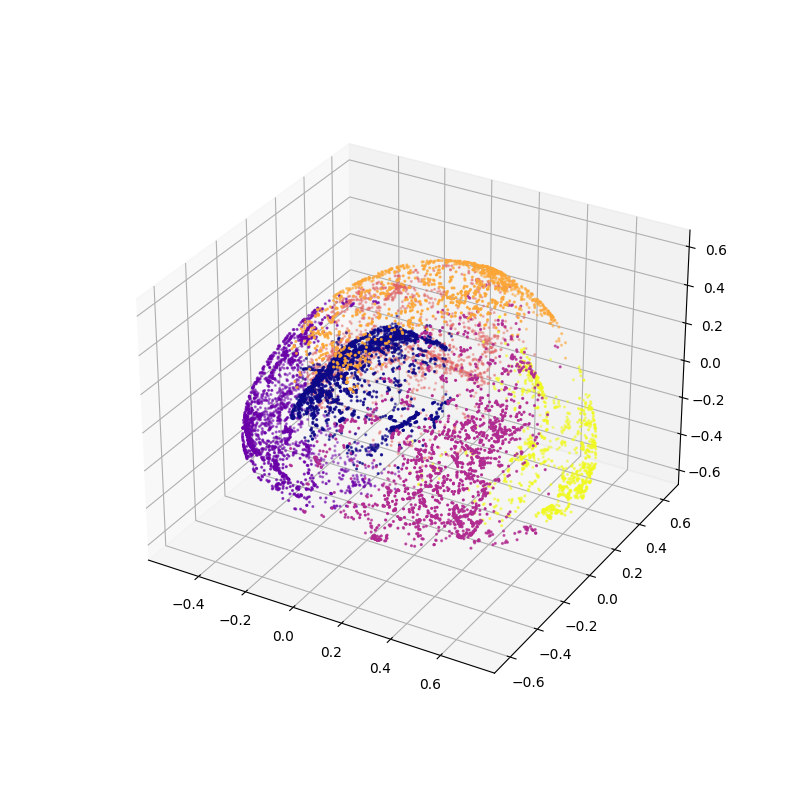

<IPython.core.display.Javascript object>


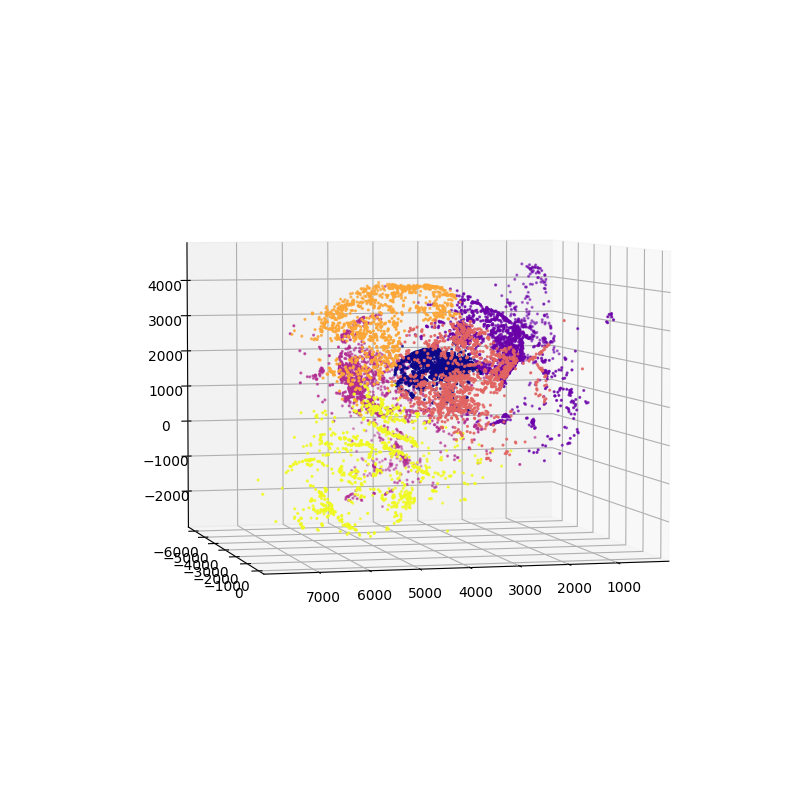

In [10]:
virgo_mixture = VirgoMixture(virgo_cluster, n_comp=6)
elbo = virgo_mixture.fit()

print(f"ELBO: {elbo}")
virgo_mixture.predict(remove_uncertain_labels=False)
labels_removed = virgo_cluster.get_labels(return_counts=True)
print(labels_removed)

virgo_cluster.plot_cluster(n_step=1, plot_kernel_space=True)
virgo_cluster.plot_cluster(n_step=1)

Found  589  groups
[-1  0  1  2  3  4  5  6] [2559 5103  994  763  163  152  148  118]


<IPython.core.display.Javascript object>


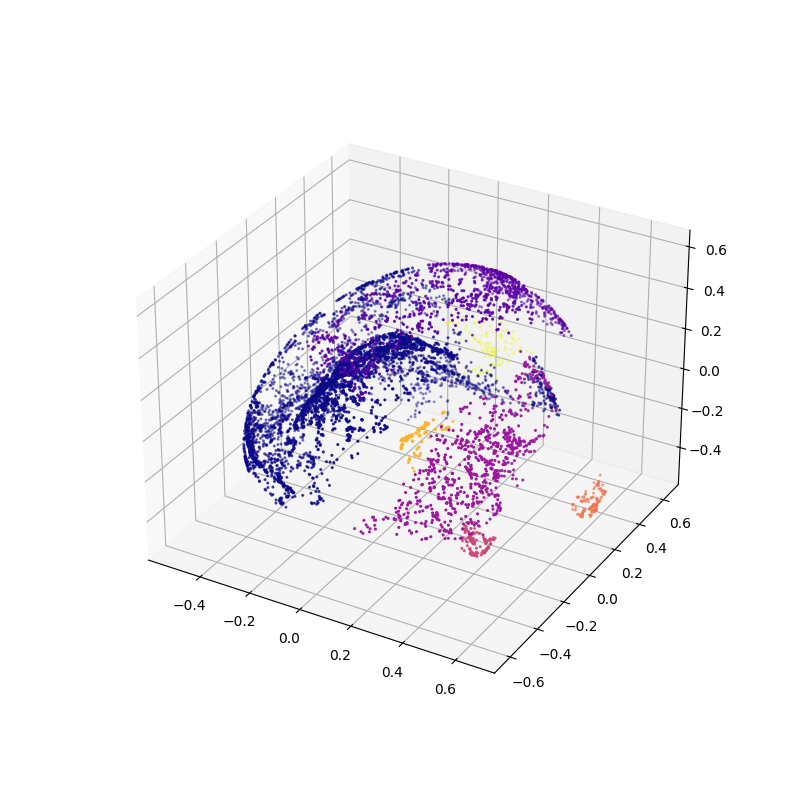

<IPython.core.display.Javascript object>


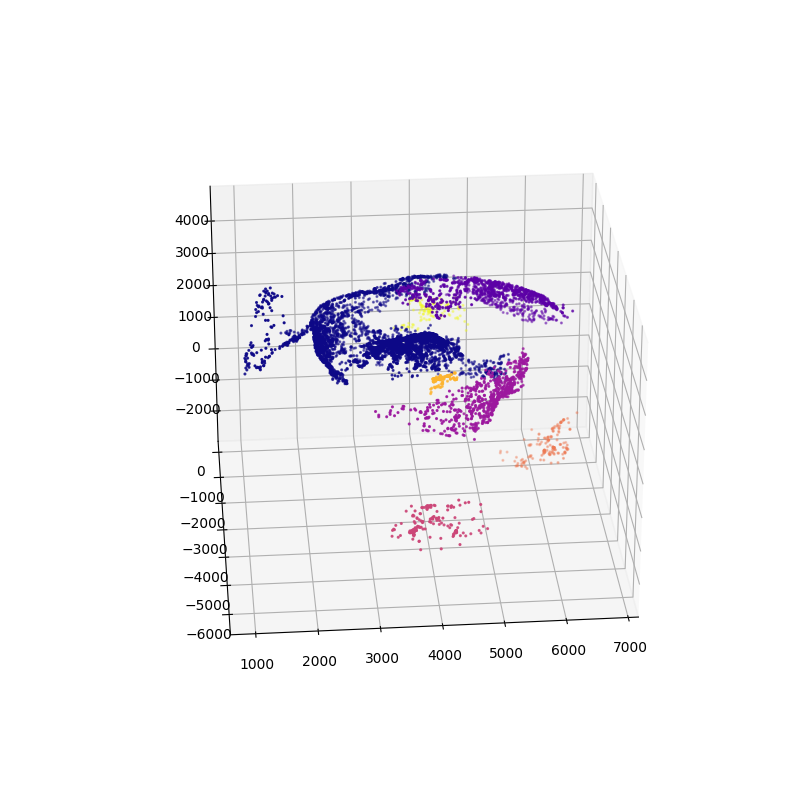

In [12]:
virgo_cluster.run_fof(
    linking_length=0.05,
    min_group_size=100,
    use_scaled_data=True,
)

labels, counts = virgo_cluster.get_labels(return_counts=True)
print(labels, counts)
virgo_cluster.plot_cluster(n_step=1, plot_kernel_space=True)
virgo_cluster.plot_cluster(n_step=1)

In [5]:
# d_cleaner = LowDensityCleaner(virgo_cluster, 1e-11)
# d_cleaner.clean()
# print(virgo_cluster.get_labels(return_counts=True))
# virgo_cluster.plot_cluster(n_step=10, plot_kernel_space=True)
# virgo_cluster.plot_cluster(n_step=10)

In [2]:
import torch
from gpytorch import kernels
import numpy as np

In [4]:
n_dim = 6
num_classes = 7
path = "/home/max/Software/virgo/demo_notebooks/dkl_pretrained.dat"

class DenseNetFeatureExtractor(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = 50
        self.hidden = 100

        self.net = torch.nn.Sequential(
            torch.nn.Linear(n_dim, self.hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(self.hidden, self.hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(self.hidden, self.num_features),
            torch.nn.ReLU(),
        )

    def forward(self, x):
        out = self.net(x)
        return out


feature_extractor = DenseNetFeatureExtractor(num_classes=num_classes)
feature_extractor.load_state_dict(torch.load(path))
feature_extractor.eval()

RuntimeError: Error(s) in loading state_dict for DenseNetFeatureExtractor:
	Missing key(s) in state_dict: "net.0.weight", "net.0.bias", "net.2.weight", "net.2.bias", "net.4.weight", "net.4.bias". 
	Unexpected key(s) in state_dict: "feature_extractor.net.0.weight", "feature_extractor.net.0.bias", "feature_extractor.net.2.weight", "feature_extractor.net.2.bias", "feature_extractor.net.4.weight", "feature_extractor.net.4.bias", "gp_layer.variational_strategy.base_variational_strategy.inducing_points", "gp_layer.variational_strategy.base_variational_strategy.variational_params_initialized", "gp_layer.variational_strategy.base_variational_strategy.grid", "gp_layer.variational_strategy.base_variational_strategy._variational_distribution.variational_mean", "gp_layer.variational_strategy.base_variational_strategy._variational_distribution.chol_variational_covar", "gp_layer.covar_module.raw_outputscale", "gp_layer.covar_module.base_kernel.raw_lengthscale", "gp_layer.covar_module.base_kernel.lengthscale_prior.a", "gp_layer.covar_module.base_kernel.lengthscale_prior.b", "gp_layer.covar_module.base_kernel.lengthscale_prior.sigma", "gp_layer.covar_module.base_kernel.lengthscale_prior.tails.loc", "gp_layer.covar_module.base_kernel.lengthscale_prior.tails.scale", "gp_layer.covar_module.base_kernel.raw_lengthscale_constraint.lower_bound", "gp_layer.covar_module.base_kernel.raw_lengthscale_constraint.upper_bound", "gp_layer.covar_module.raw_outputscale_constraint.lower_bound", "gp_layer.covar_module.raw_outputscale_constraint.upper_bound", "gp_layer.mean_module.constant", "scale_to_bounds.min_val", "scale_to_bounds.max_val". 

In [30]:
with torch.no_grad():
    test_vec = torch.tensor([[0., 0., 0., 0., 1., 0.], [0., 0., 0., 0., 1., 1.]])
    print(feature_extractor(test_vec))

tensor([[0.0000, 0.0532, 0.0039, 0.0000, 0.0000, 0.0459, 0.0841, 0.0000, 0.0493,
         0.0000, 0.0000, 0.0000, 0.0015, 0.1887, 0.1399, 0.0444, 0.0000, 0.0579,
         0.0000, 0.0000, 0.0000, 0.0534, 0.0000, 0.0000, 0.0000, 0.0834, 0.1001,
         0.0730, 0.1293, 0.0533, 0.0990, 0.0327, 0.0000, 0.0262, 0.0000, 0.1408,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0134, 0.0000, 0.1754,
         0.0256, 0.0000, 0.0922, 0.0000, 0.0400],
        [0.0000, 0.0842, 0.0000, 0.0000, 0.0000, 0.0361, 0.1016, 0.0000, 0.0307,
         0.0000, 0.0000, 0.0000, 0.0141, 0.2344, 0.2026, 0.1412, 0.0000, 0.0374,
         0.0000, 0.0000, 0.0107, 0.0443, 0.0000, 0.0000, 0.0000, 0.0641, 0.1201,
         0.0629, 0.1290, 0.0402, 0.0989, 0.0279, 0.0000, 0.0503, 0.0000, 0.2028,
         0.0000, 0.0058, 0.0000, 0.0000, 0.0000, 0.0000, 0.0440, 0.0000, 0.1978,
         0.0160, 0.0000, 0.1587, 0.0000, 0.0871]])


(100000, 7) (100000,)


<IPython.core.display.Javascript object>


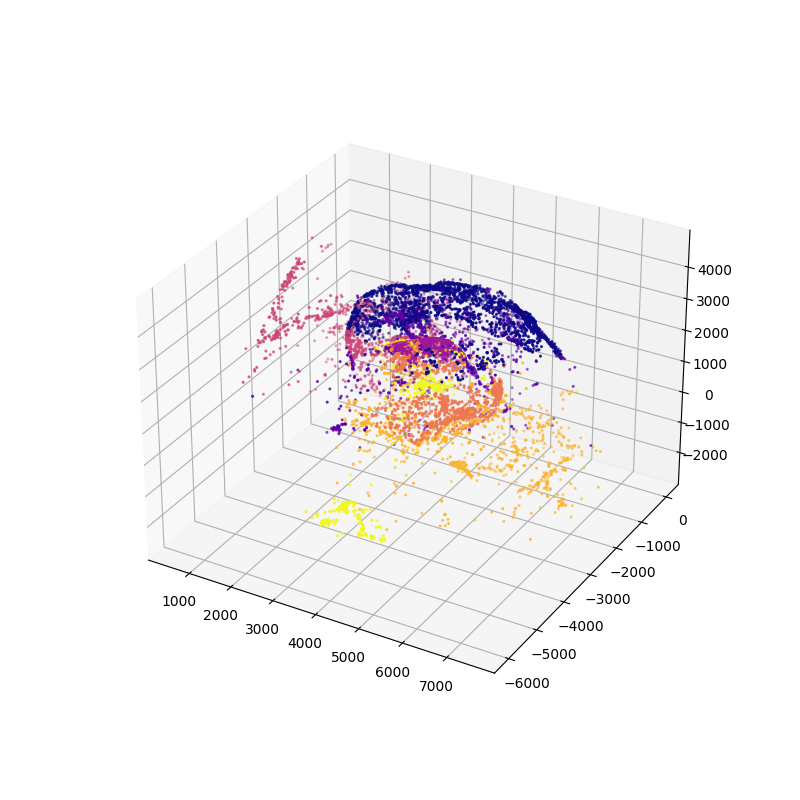

<IPython.core.display.Javascript object>


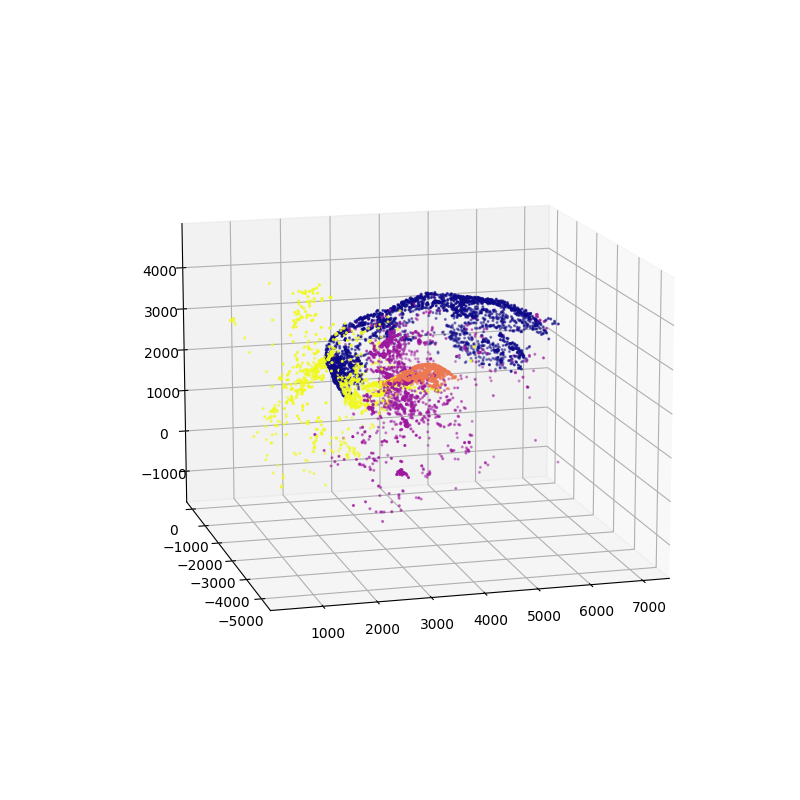

In [17]:
cluster = np.loadtxt("/home/max/Software/virgo/demo_notebooks/vc_post_dkl_cluster.txt")
labs = np.loadtxt("/home/max/Software/virgo/demo_notebooks/vc_post_dkl_cluster_labels.txt")
virgo_cluster = VirgoCluster(None)
virgo_cluster.cluster = cluster
virgo_cluster.cluster_labels = labs

print(cluster.shape, labs.shape)
virgo_cluster.plot_cluster(n_step=10)
virgo_cluster.plot_cluster(n_step=10, cluster_label=[0, 1, 2, 3])

Cluster 0.0
Density: 6.347054422007826e-05
Cluster 1.0
Density: 1.1567605619603515e-05
Cluster 2.0
Density: 0.0019213503017950586
Cluster 3.0
Density: 2.4172323668151873e-05
Cluster 4.0
Density: 6.267696381976847e-05
Cluster 5.0
Density: 1.286300265624526e-05
Cluster 6.0
Density: 1.273527038839339e-05
(array([-1.,  0.,  1.,  2.,  3.]), array([35047, 25114, 14142, 13387, 12310]))


<IPython.core.display.Javascript object>


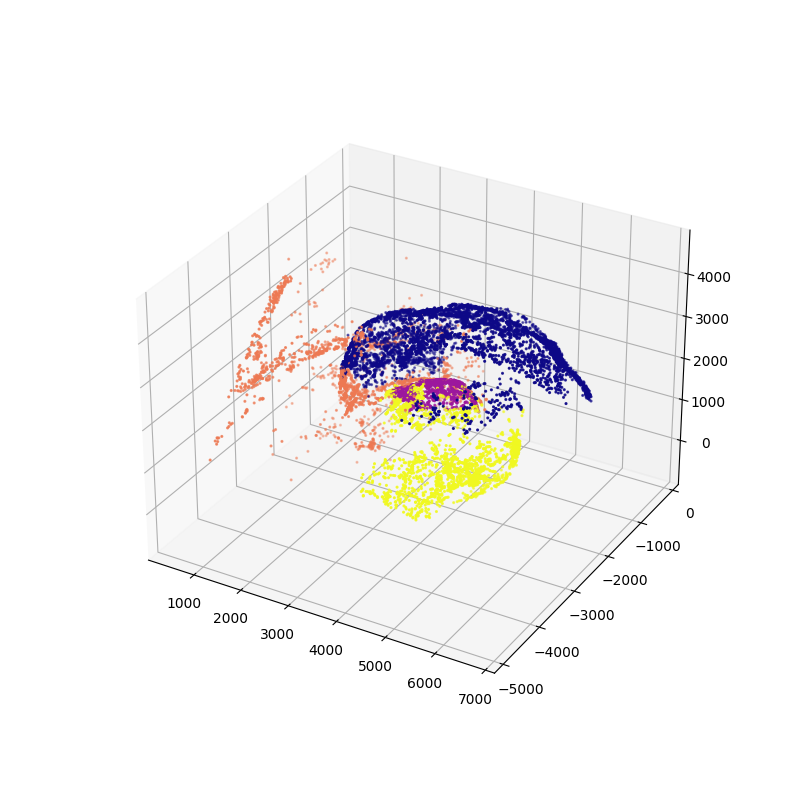

In [19]:
d_cleaner = LowDensityCleaner(virgo_cluster, 2e-5)
d_cleaner.clean()
print(virgo_cluster.get_labels(return_counts=True))
virgo_cluster.plot_cluster(n_step=5)

<IPython.core.display.Javascript object>


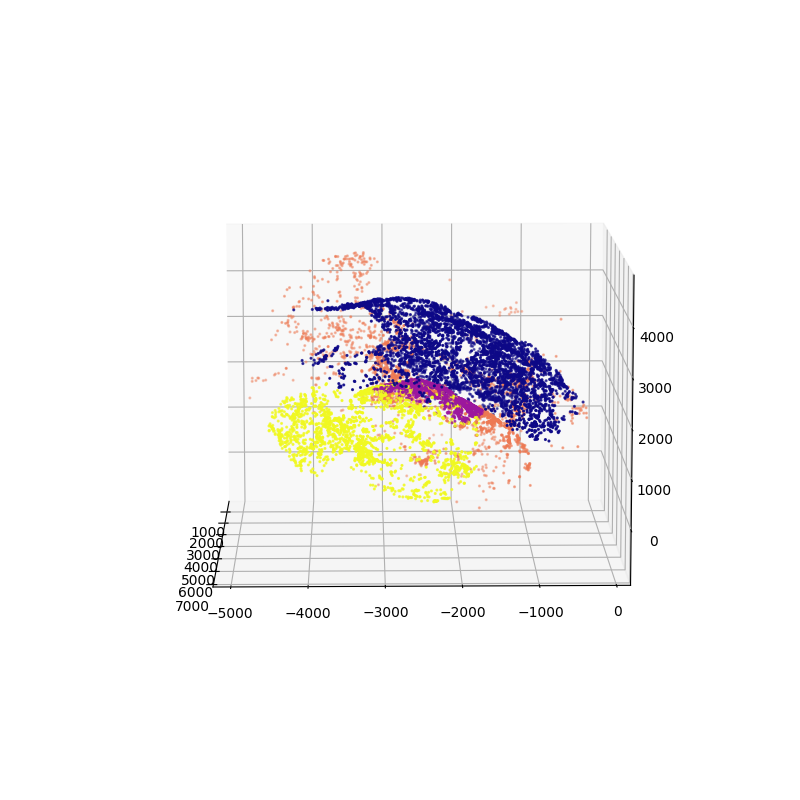

MovieWriter imagemagick unavailable; using Pillow instead.


In [20]:
virgo_cluster.plot_cluster(n_step=5, store_gif=True, gif_title="post_dkl_gmm")

In [2]:
import numpy as np

Data set 0 - Shape: (131438, 8)
Mean / Std: 26648.482 / 81836.402
Min / Max: -4588.501 / 578948.000
Data set 1 - Shape: (131438, 10)
Mean / Std: -11.499 / 48.881
Min / Max: -208.206 / 242.787
(131438, 8) (131438,)


<IPython.core.display.Javascript object>


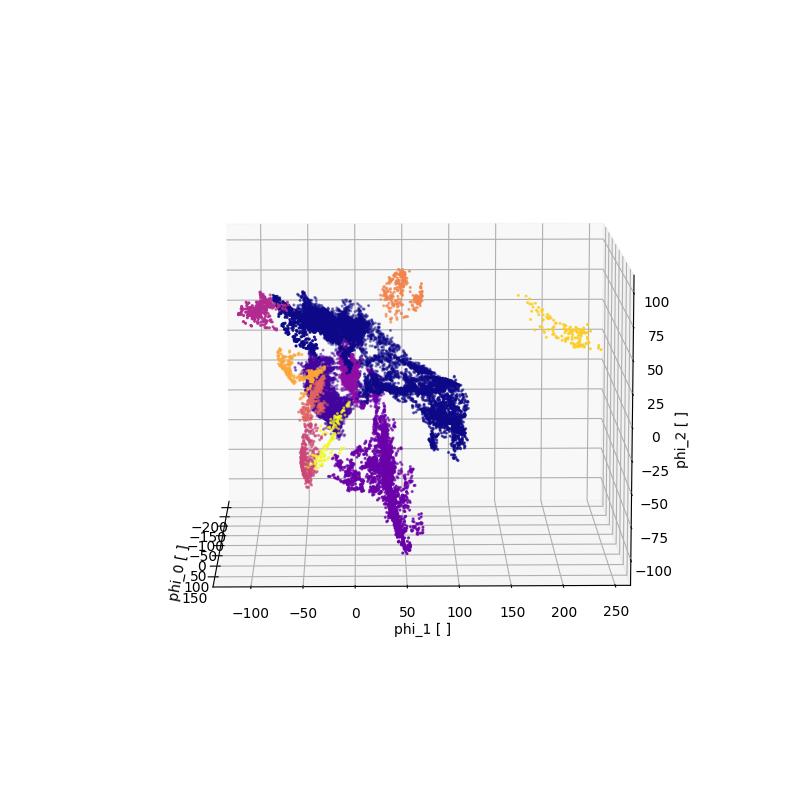

MovieWriter imagemagick unavailable; using Pillow instead.


<IPython.core.display.Javascript object>


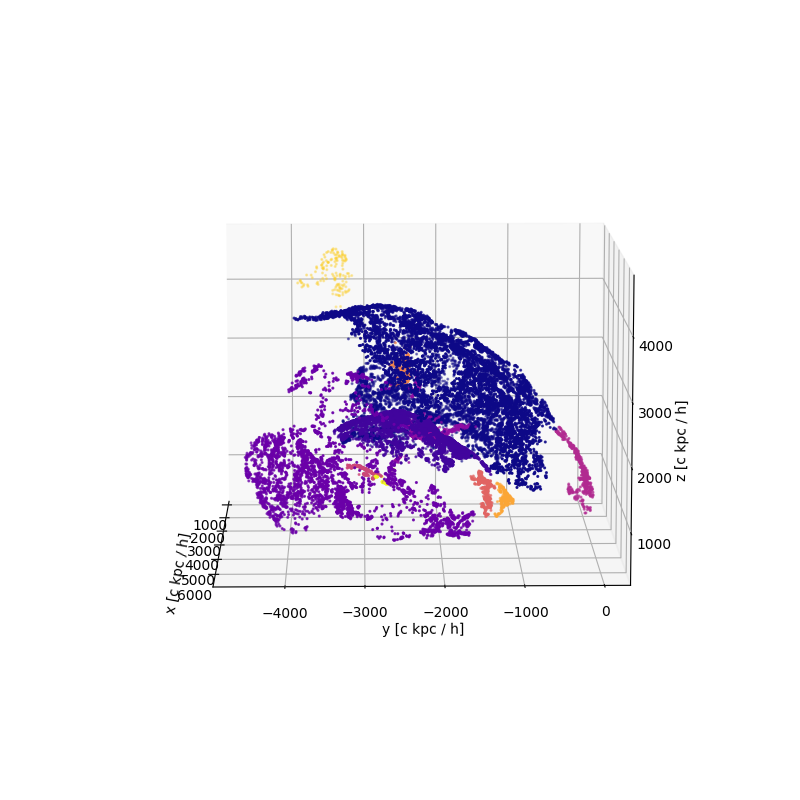

MovieWriter imagemagick unavailable; using Pillow instead.


<IPython.core.display.Javascript object>


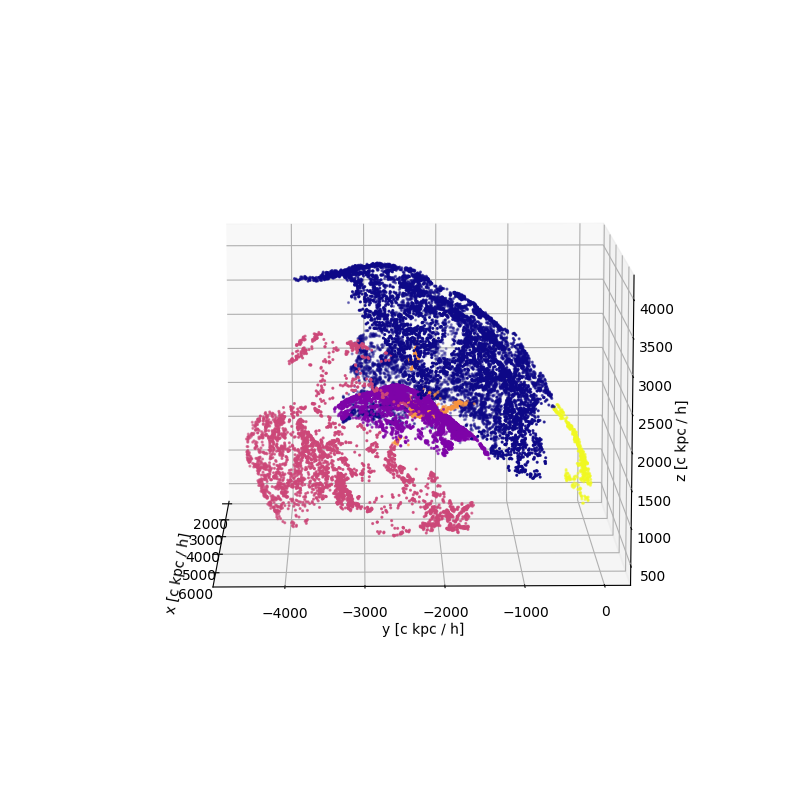

MovieWriter imagemagick unavailable; using Pillow instead.


In [5]:
cluster = np.loadtxt("/home/max/Software/virgo/demo_notebooks/vc_post_dkl_cluster.txt")
labs = np.loadtxt("/home/max/Software/virgo/demo_notebooks/vc_post_dkl_cluster_labels.txt")
scaled = np.loadtxt("/home/max/Software/virgo/demo_notebooks/vc_post_dkl_scaled_data.txt")
data = np.loadtxt("/home/max/Software/virgo/demo_notebooks/vc_post_dkl_data.txt")

virgo_cluster = VirgoCluster(None)
virgo_cluster.data = data
virgo_cluster.scaled_data = scaled
virgo_cluster.cluster = cluster
virgo_cluster.cluster_labels = labs
virgo_cluster.print_datastats()


print(cluster.shape, labs.shape)
virgo_cluster.plot_cluster(n_step=5, plot_kernel_space=True, store_gif=True, gif_title="dkl_fof_kernelspace")
virgo_cluster.plot_cluster(n_step=5, store_gif=True, gif_title="dkl_fof")
virgo_cluster.plot_cluster(n_step=5, cluster_label=[0, 1, 2, 3, 4], store_gif=True, gif_title="dkl_fof_zoom")

Found  11  groups
10
[-1  0  1  2  3  4  5  6  7  8] [ 1682 52841 47232 16410  4614  2309  1844  1802  1369  1335]


<IPython.core.display.Javascript object>


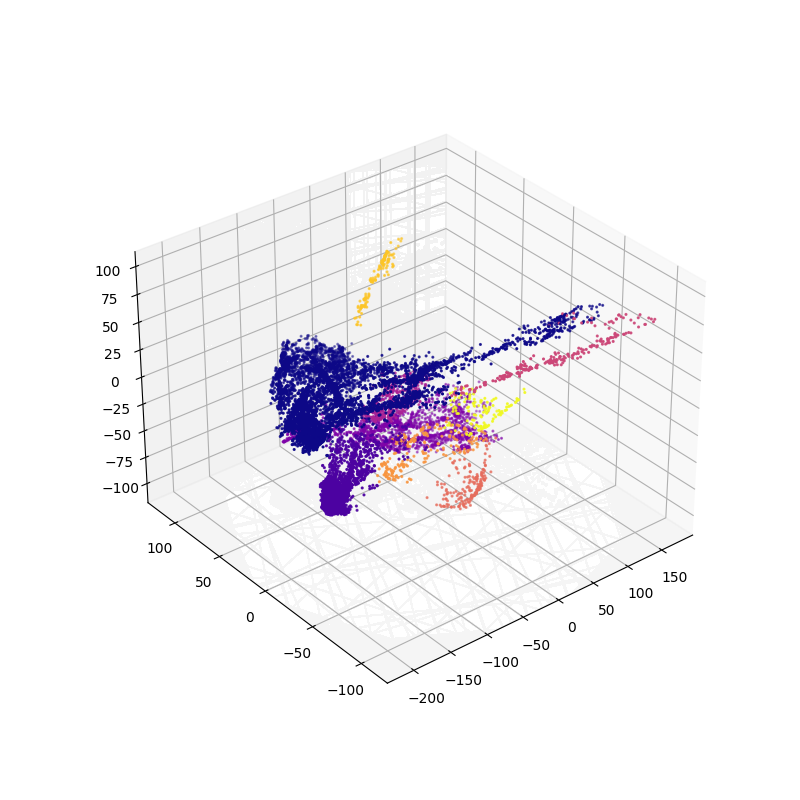

<IPython.core.display.Javascript object>


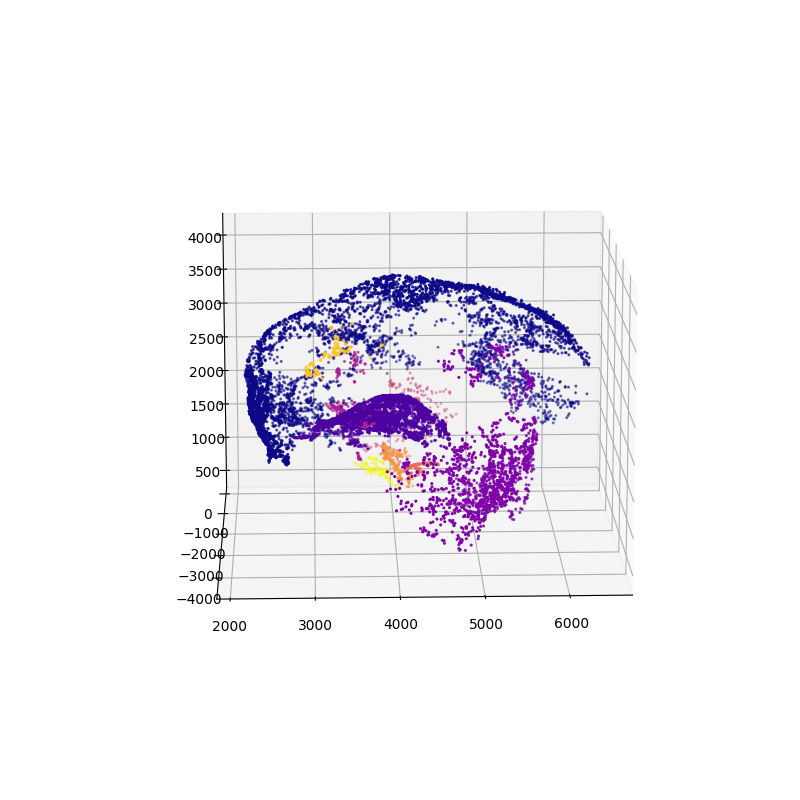

In [18]:
virgo_cluster.run_fof(linking_length=4.95, min_group_size=1000, use_scaled_data=True) # 4.50


labels, counts = virgo_cluster.get_labels(return_counts=True)
print(len(labels))
print(labels, counts)
virgo_cluster.plot_cluster(n_step=10, plot_kernel_space=True)
virgo_cluster.plot_cluster(n_step=10)

In [38]:
scaled = np.loadtxt("/home/max/Software/virgo/demo_notebooks/vc_post_dkl_rawscaled_data.txt")
data = np.loadtxt("/home/max/Software/virgo/demo_notebooks/vc_post_dkl_rawdata.txt")

virgo_cluster = VirgoCluster(None)
virgo_cluster.data = data[::4]
virgo_cluster.scaled_data = scaled[::4]
virgo_cluster.print_datastats()

Data set 0 - Shape: (144781, 8)
Mean / Std: 36663.454 / 112566.286
Min / Max: -6264.293 / 579122.000
Data set 1 - Shape: (144781, 10)
Mean / Std: 0.071 / 67.161
Min / Max: -171.408 / 918.178


Found  13686  groups
7
[-1  0  1  2  3  4  5] [38238 51925 21773 15658 14391  1609  1187]


<IPython.core.display.Javascript object>


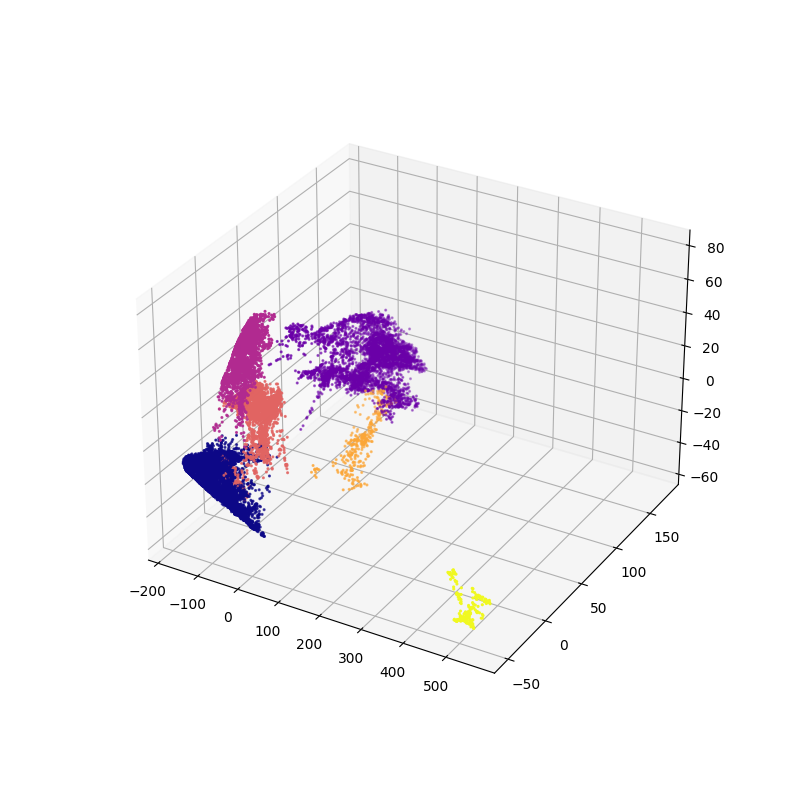

<IPython.core.display.Javascript object>


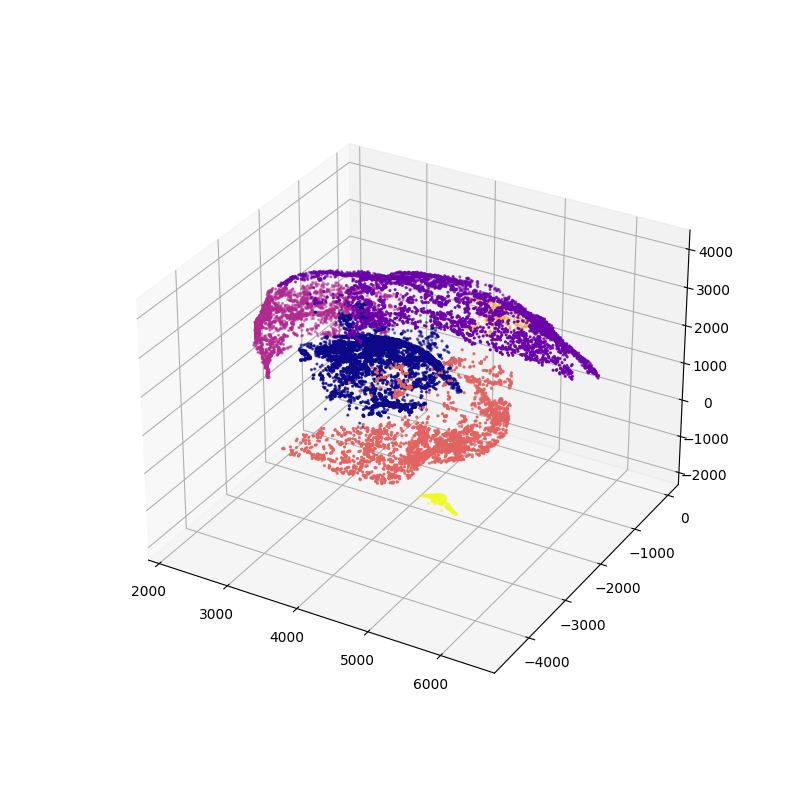

In [40]:
virgo_cluster.run_fof(linking_length=4.55, min_group_size=800, use_scaled_data=True) # [[::5] 4.50 / 4.95, [::3] 4.6]


labels, counts = virgo_cluster.get_labels(return_counts=True)
print(len(labels))
print(labels, counts)
virgo_cluster.plot_cluster(n_step=5, plot_kernel_space=True)
virgo_cluster.plot_cluster(n_step=5)

In [ ]:
# virgo_cluster.plot_cluster(n_step=3, plot_kernel_space=True, store_gif=True, gif_title="dkl_fof_kernelspace")
# virgo_cluster.plot_cluster(n_step=3, store_gif=True, gif_title="dkl_fof")
# virgo_cluster.plot_cluster(n_step=3, cluster_label=[0, 1, 2, 3, 4], store_gif=True, gif_title="dkl_fof_zoom")

In [44]:
import torch

In [51]:
t1 = (torch.rand((10, 3)) - 0.5) * 100
t2 = (torch.rand((10, 3)) - 0.5) * 0.1
print(t1)
print(t2)

tensor([[-24.0451, -11.1215, -24.7739],
        [ 11.9896,  13.5713,  17.8573],
        [ 19.4030, -39.3050,  10.2141],
        [-44.5232, -36.7050, -49.4138],
        [ 42.0451,   8.7758, -25.6590],
        [ 11.9325,  -8.2107,  27.5138],
        [-18.5766,  13.2495, -44.9607],
        [ 41.3888,  26.3988,  12.3885],
        [-43.2452,  16.3090,  41.4242],
        [-26.7348,  22.3569,  37.6580]])
tensor([[-0.0326, -0.0370,  0.0154],
        [ 0.0069,  0.0029, -0.0489],
        [ 0.0099,  0.0307,  0.0122],
        [ 0.0154, -0.0108, -0.0200],
        [ 0.0201,  0.0143,  0.0055],
        [ 0.0159, -0.0177,  0.0329],
        [-0.0180, -0.0276, -0.0373],
        [ 0.0036, -0.0046, -0.0084],
        [-0.0418, -0.0249, -0.0008],
        [-0.0235, -0.0422, -0.0482]])


In [52]:
torch.cat([t1, t2], 1)

tensor([[-2.4045e+01, -1.1121e+01, -2.4774e+01, -3.2612e-02, -3.6973e-02,
          1.5415e-02],
        [ 1.1990e+01,  1.3571e+01,  1.7857e+01,  6.9047e-03,  2.8960e-03,
         -4.8915e-02],
        [ 1.9403e+01, -3.9305e+01,  1.0214e+01,  9.9449e-03,  3.0736e-02,
          1.2226e-02],
        [-4.4523e+01, -3.6705e+01, -4.9414e+01,  1.5400e-02, -1.0820e-02,
         -1.9951e-02],
        [ 4.2045e+01,  8.7758e+00, -2.5659e+01,  2.0094e-02,  1.4294e-02,
          5.4663e-03],
        [ 1.1932e+01, -8.2107e+00,  2.7514e+01,  1.5877e-02, -1.7721e-02,
          3.2861e-02],
        [-1.8577e+01,  1.3249e+01, -4.4961e+01, -1.8028e-02, -2.7642e-02,
         -3.7348e-02],
        [ 4.1389e+01,  2.6399e+01,  1.2388e+01,  3.6176e-03, -4.5990e-03,
         -8.3644e-03],
        [-4.3245e+01,  1.6309e+01,  4.1424e+01, -4.1801e-02, -2.4906e-02,
         -7.9728e-04],
        [-2.6735e+01,  2.2357e+01,  3.7658e+01, -2.3451e-02, -4.2244e-02,
         -4.8159e-02]])

In [6]:
from scipy.interpolate import interpn

def value_func_3d(x, y, z):

    return 2 * x + 3 * y - z

x = np.linspace(0, 4, 5)

y = np.linspace(0, 5, 6)

z = np.linspace(0, 6, 7)

points = (x, y, z)

values = value_func_3d(*np.meshgrid(*points, indexing='ij'))

In [11]:
point = np.array([[2.21, 3.12, 1.15]] * 1000000)

print(interpn(points, values, point))

[12.63 12.63 12.63 ... 12.63 12.63 12.63]


In [10]:
[[2.21, 3.12, 1.15]] * 10

[[2.21, 3.12, 1.15],
 [2.21, 3.12, 1.15],
 [2.21, 3.12, 1.15],
 [2.21, 3.12, 1.15],
 [2.21, 3.12, 1.15],
 [2.21, 3.12, 1.15],
 [2.21, 3.12, 1.15],
 [2.21, 3.12, 1.15],
 [2.21, 3.12, 1.15],
 [2.21, 3.12, 1.15]]